In [197]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [198]:
filename_negs = glob.glob('neg/cv0**.txt')
filename_pos = glob.glob('pos/cv0**.txt')

In [199]:
def makelist(filenames):
    list_of_dfs = []
    for filename in filenames:
        chunk = ""
        with open(filename) as f:
            chunk = f.readlines()
        list_of_dfs.append(chunk)
        
    return list_of_dfs
#[pd.read_csv(filename, sep = '\Z') ]


In [200]:
dfneg = pd.DataFrame([makelist(filename_negs)]).T
dfneg.rename(index = str, columns={0: "reviews"})
dfpos = pd.DataFrame([makelist(filename_pos)]).T
dfpos.rename(index = str, columns={0: "reviews"})

,reviews
0,[films adapted from comic books have had plent...
1,[every now and then a movie comes along from a...
2,[you've got mail works alot better than it des...
3,"[ "" jaws "" is a rare film that grabs your atte..."
4,[moviemaking is a lot like being the general m...
5,"[on june 30 , 1960 , a self-taught , idealisti..."
6,"[apparently , director tony kaye had a major b..."
7,[one of my colleagues was surprised when i tol...
8,"[after bloody clashes and independence won , l..."
9,[the american action film has been slowly drow...


In [201]:
def addsent(val):
    sent = []
    for i in range (0, 100):
        sent.append(val)
    return sent 

In [202]:
dfneg['sentiment'] = addsent(0) #negative sentiment denoted by 0
dfneg['rating'] = np.random.randint(1,3,100)
dfpos['sentiment'] = addsent(1) #positive sentiment denoted by 1
dfpos['rating'] = np.random.randint(4,6,100)

In [203]:
msk = np.random.rand(len(dfneg)) < 0.8

In [204]:
dfneg_training = dfneg[msk]
dfneg_test = dfneg[~msk]
dfpos_training = dfpos[msk]
dfpos_test = dfpos[~msk]

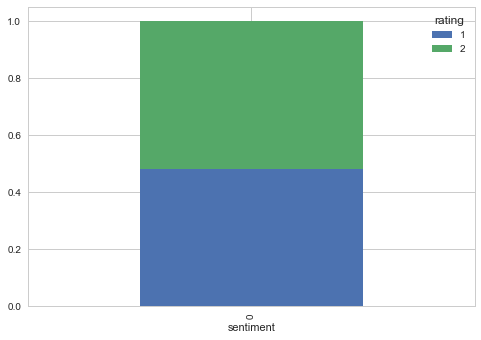

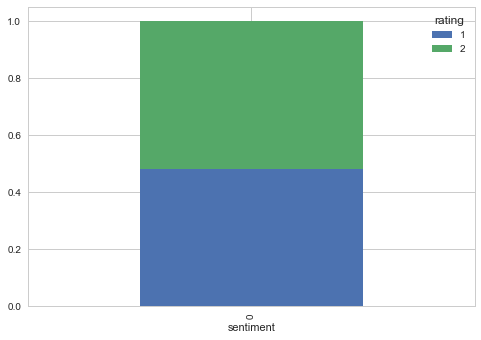

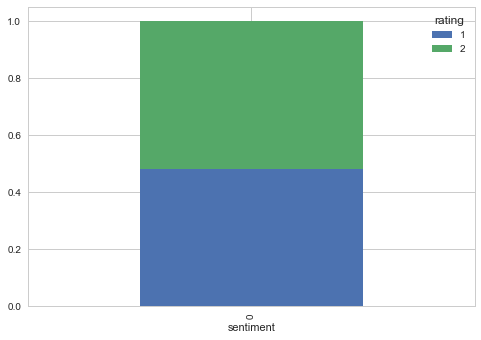

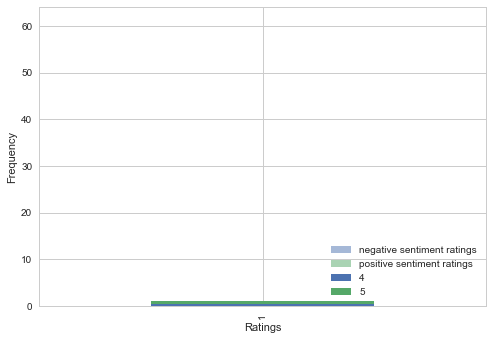

In [205]:
bins = np.linspace(0, 6, 10)
plt.hist(dfneg['rating'], bins, alpha=0.5, label='negative sentiment ratings')
plt.hist(dfpos['rating'], bins, alpha=0.5, label='positive sentiment ratings')
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.legend(loc='lower right')
plt.show()

In [206]:
#since the data has been divided into training and test set, we can now run a machine learning classifier on our data 

In [207]:
training_data = dfneg_training.append(dfpos_training)
test_data = dfneg_test.append(dfpos_test)

In [208]:
#training labels are the binary values 0 and 1 so we have to pass in the sentiments 
#training_data['sentiment'] = labels

In [225]:
print training_data['rating'].reshape(-1,1)
print training_data['sentiment'].reshape(-1,1)

[[1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [1]
 [2]
 [2]
 [1]
 [2]
 [1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [1]
 [2]
 [2]
 [2]
 [2]
 [1]
 [2]
 [1]
 [2]
 [1]
 [1]
 [1]
 [2]
 [1]
 [2]
 [2]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [2]
 [1]
 [2]
 [2]
 [2]
 [1]
 [2]
 [2]
 [2]
 [2]
 [1]
 [2]
 [1]
 [2]
 [2]
 [2]
 [2]
 [1]
 [1]
 [2]
 [1]
 [2]
 [1]
 [2]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [1]
 [1]
 [1]
 [2]
 [1]
 [2]
 [1]
 [2]
 [2]
 [5]
 [4]
 [4]
 [4]
 [5]
 [5]
 [5]
 [5]
 [4]
 [5]
 [4]
 [4]
 [4]
 [5]
 [4]
 [5]
 [5]
 [4]
 [5]
 [5]
 [4]
 [5]
 [4]
 [5]
 [5]
 [5]
 [5]
 [4]
 [4]
 [5]
 [4]
 [5]
 [5]
 [5]
 [5]
 [5]
 [4]
 [4]
 [5]
 [4]
 [4]
 [4]
 [5]
 [4]
 [5]
 [4]
 [5]
 [4]
 [4]
 [5]
 [5]
 [5]
 [5]
 [4]
 [4]
 [5]
 [5]
 [4]
 [5]
 [4]
 [4]
 [4]
 [5]
 [5]
 [5]
 [5]
 [4]
 [4]
 [4]
 [5]
 [5]
 [5]
 [4]
 [4]
 [4]
 [5]
 [5]
 [4]
 [4]
 [5]
 [5]
 [5]
 [5]
 [5]]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]

C:\Users\Souparni Agnihotri\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

C:\Users\Souparni Agnihotri\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



In [229]:
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(training_data['rating'].values.reshape(-1,1), training_data['sentiment'].values.reshape(-1,1))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [230]:
y_pred = logreg.predict(test_data['rating'].values.reshape(-1,1))

In [231]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_data['rating'].values.reshape(-1,1), test_data['sentiment'].values.reshape(-1,1))))

Accuracy of logistic regression classifier on test set: 1.00
